In [1]:
from transmitter import *
from reciever import *
import numpy as np
from scipy.signal import chirp, spectrogram
import simpleaudio as sa
from scipy.io.wavfile import write, read
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

In [2]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 60                   # Symbols per frame

ofdm.num_tones = 21             # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.rate = "1/2"
ofdm.z = 81

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}

ofdm.pilot_vals

array([1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j,
       1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j,
       1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j])

Length of bytes 26800.0
256


-0.10003274541687134

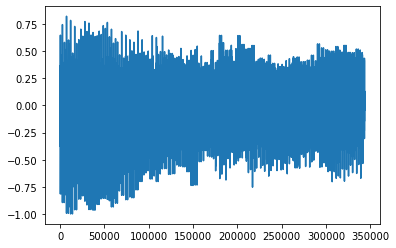

In [3]:
bit_array = bitsFromTiff('jaguar.tiff')
print('Length of bytes', len(bit_array)/8)

payload = fullTrans(bit_array, ofdm)
payload = payload / np.max(np.abs(payload.flatten()))
plt.plot((payload.flatten()))
np.max(np.abs(payload))
payload.flatten()[0]

In [4]:
data = bit_array
ldpc = LDPC(rate = ofdm.rate, z = ofdm.z)
ldpc_ified = ldpc.encode(data)

symb = bit2symbol(ldpc_ified, ofdm)

cut_symb = cut2Blocks(symb, ofdm)
# syb_padded = addpadding(cut_symb, ofdm)
all_symbs = goodSymbols(cut_symb,ofdm)
print(np.shape(all_symbs))
print(all_symbs[4][2048-ofdm.pilot_locs])
tds = ifft(all_symbs, 2048)
#print(addGuard(tds, ofdm))

(299, 2048)
[1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j
 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j
 1.-1.j]


In [5]:
def CUSTARDtrial(payload,ofdm):
    chirp = double_chirp().flatten()
    exported_even, exported_odd = np.loadtxt('preamble_ofdm_symbols.csv',delimiter=',')
    two_snc = np.concatenate((exported_even, exported_odd)).flatten()
    four_snc = np.concatenate((two_snc, two_snc)).flatten()

    transmission = np.concatenate((chirp,four_snc))
    for i in range(len(payload)//ofdm.sfp):
        transmission = np.concatenate((transmission, payload[i*60:60*i+60].flatten(), two_snc))
    if len(payload)%ofdm.sfp != 0:
        transmission = np.concatenate((transmission, payload[-(len(payload)%ofdm.sfp):].flatten(), chirp))
    else:
        transmission = np.concatenate((transmission, chirp))
    
    return transmission

In [6]:
payload[-59:]
lens = -(len(payload)%ofdm.sfp)
len(payload[lens:])


29

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

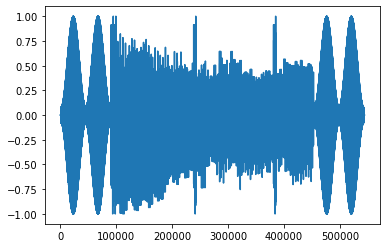

In [7]:
x = CUSTARDtrial(payload, ofdm)
plt.plot(x)
audioMaker(x, 'jagtest', fs)

In [8]:
chirp_time = 1
t = np.linspace(0, chirp_time, int(chirp_time * fs), False)
note = chirp(t, f0=500, f1=15000, t1=chirp_time, method='linear')
note = note*np.hamming(len(note))

#delay_guess2 = np.abs(np.correlate(x, note, mode='full'))


In [9]:
plt.plot(delay_guess)
peaks = scipy.signal.find_peaks(delay_guess, 7000)[1]['peak_heights']


NameError: name 'delay_guess' is not defined

91200


array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

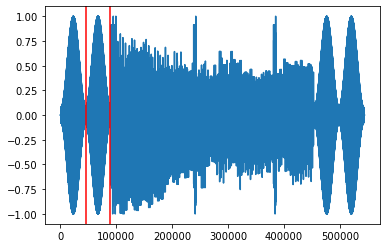

In [54]:

plt.plot(x)
plt.axvline(x = 45600 , color = 'r') 
plt.axvline(x = 89700 , color = 'r')
1500+44100,1500+44100*2
print((44100+1500)*2)
audioMaker(x, 'testframe2', fs)

In [59]:
def channelEstimate(four_known_symbols, ofdm):

    even_one = four_known_symbols[:ofdm.N+ofdm.CP]
    odd_one = four_known_symbols[ofdm.N+ofdm.CP:2*(ofdm.N+ofdm.CP)]
    even_two = four_known_symbols[2*(ofdm.N+ofdm.CP):3*(ofdm.N+ofdm.CP)]
    odd_two = four_known_symbols[3*(ofdm.N+ofdm.CP):4*(ofdm.N+ofdm.CP)]
    odd_index = np.arange(0,741,2)
    even_index=np.arange(1,741,2)

    exported_coding = np.loadtxt('preamble_qpsk_symbols.csv', delimiter=',',dtype=complex)
    exported_coding *= 1.41421356474619

    hes_e1 = (fft(even_one[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_o1 = (fft(odd_one[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_e2 = (fft(even_two[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_o2 = (fft(odd_two[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    
    hest_one = np.zeros(741, dtype='complex')
    hest_one[even_index] = hes_e1[even_index]
    hest_one[odd_index] = hes_o1[odd_index]

    hest_two = np.zeros(741, dtype='complex')
    hest_two[even_index] = hes_e2[even_index]
    hest_two[odd_index] = hes_o2[odd_index]


    return hest_one, hest_two


def chanest_padd(hest,ofdm):
    full_size = np.ones(ofdm.N, dtype='complex')
    full_size[49:790] = hest
    return full_size


end_of_chirps = scipy.signal.find_peaks(delay_guess, 7000)[0]
#a,b = channelEstimate(x[end_of_chirps[1]+1501:end_of_chirps[1]+1501+2304*4], ofdm)


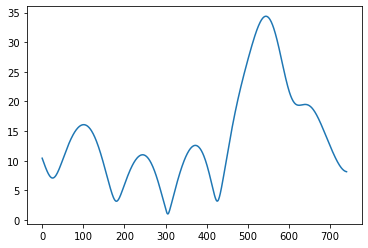

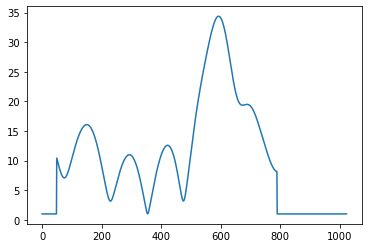

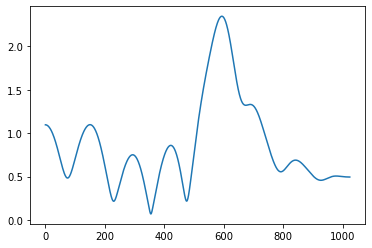

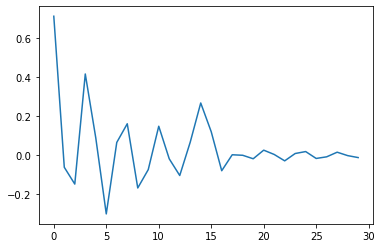

In [60]:
channel = np.array(['0.711725', '-0.0612732', '-0.147167', '0.41624', '0.0892594',
       '-0.299867', '0.0658993', '0.161483', '-0.167087', '-0.0731453',
       '0.148812', '-0.0179479', '-0.103307', '0.0674107', '0.267815',
       '0.120747', '-0.0788446', '0.00283828', '0.000199786',
       '-0.0176253', '0.0264058', '0.00439817', '-0.0282967',
       '0.00925993', '0.0192252', '-0.0160353', '-0.00768739',
       '0.0159742', '-0.00150132', '-0.0115726']).astype(np.float64)

def addChannel(signal, chan = channel):       
    return np.convolve(signal, chan)

x2 = addChannel(x,channel)
a,b = channelEstimate(x2[91200:91200+2304*4], ofdm)

plt.plot(abs(a))
plt.show()
plt.plot(abs(chanest_padd(b,ofdm)))
plt.show()
plt.plot(abs(fft(channel, 2048))[:1024])
plt.show()
plt.plot((channel))
plt.show()

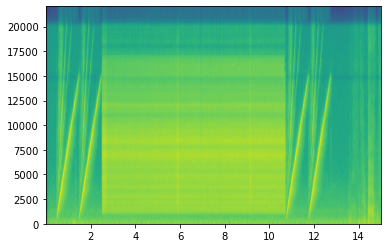

In [11]:
Fs, auds = read('fullframetest2.wav')

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(auds, Fs=fs)
plt.show()

In [12]:

chirp_time = 1
t = np.linspace(0, chirp_time, int(chirp_time * fs), False)
note = chirp(t, f0=500, f1=15000, t1=chirp_time, method='linear')
note = note*np.hamming(len(note))

delay_guess = np.abs(np.correlate(auds, note, mode='full'))

(array([ 65027, 109126, 517949, 562048]),
 {'peak_heights': array([662.46584359, 634.31839339, 658.2763809 , 642.31314206])})

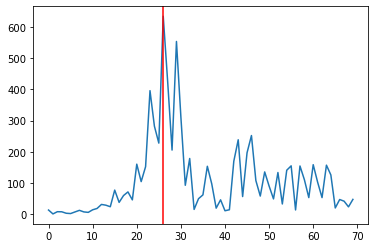

In [19]:
plt.plot(delay_guess[109100:109170])
plt.axvline(x = 26 , color = 'r')

scipy.signal.find_peaks(delay_guess, 600)

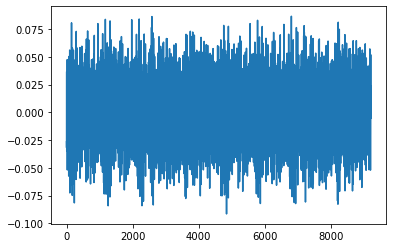

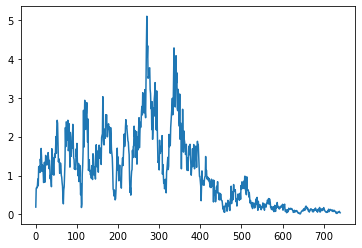

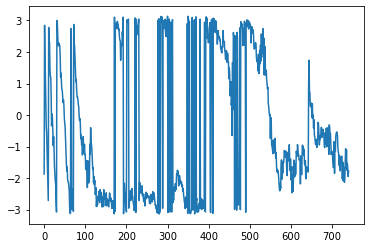

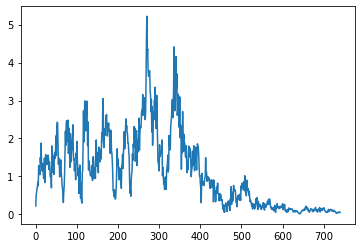

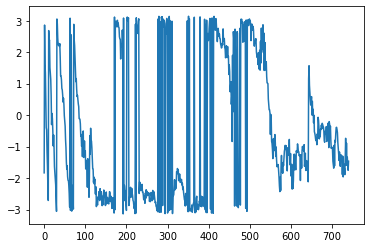

In [24]:
plt.plot(auds[109126+1501:109126+1501+2304*4])
plt.show()
ayy,bee = channelEstimate(auds[109126+1501:109126+1501+2304*4], ofdm)

plt.plot(abs(ayy))
plt.show()
plt.plot(np.angle(ayy))
plt.show()
plt.plot(abs(bee))
plt.show()
plt.plot(np.angle(bee))
plt.show()

In [ ]:
sc_indices = [i for i in range(0,400) if (i ==0 or i== 1) or i % 60 != 0 and (i-1)%60 != 0] 
print(sc_indices[55:65])

"""for i in range(0,400):
    if (i ==0 or i== 1) or i % 60 != 0 and (i-1)%60 != 0:
        print(i)
    else:
        pass"""

[55, 56, 57, 58, 59, 62, 63, 64, 65, 66]


'for i in range(0,400):\n    if (i ==0 or i== 1) or i % 60 != 0 and (i-1)%60 != 0:\n        print(i)\n    else:\n        pass'

472355 472348


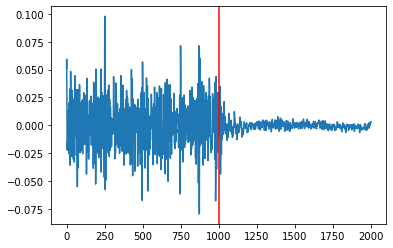

In [49]:
delayed_end = 517949-44100-1500 - 1
delayed_start = 109126 + 1500 + 1

num_symbs_guess = round((delayed_end-delayed_start)/2304)
new_end = delayed_start + num_symbs_guess*2304

plt.plot(auds[new_end-1000:new_end+1000])
plt.axvline(x = 1000 , color = 'r')
print(new_end, delayed_end)
decoded = standard_deconstructor(auds[delayed_start:new_end], ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = False)


In [33]:
decoded[:214400], len(decoded)

(array([1, 1, 0, ..., 1, 0, 1]), 220320)

In [31]:
initial = bit_array
initial, len(initial)

(array([1, 1, 1, ..., 1, 1, 1]), 214400)

In [42]:
j = 0
r = 60*720*2
for i in range(r):
    if initial[i] == decoded[i]:
        j+=1
j/r

0.5885763888888889

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])